# Benhcmark model tutor

In [32]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

import datetime
import time
import random
import string
import os
import json
import random
import string
from pprint import pformat
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
# logging.debug("test")
# logging.basicConfig(filename='./temp_tutor.log', level=logging.INFO)



# --- Dependencies
import pygmo as pg
import numpy as np
import pandas as pd

from sklearn.model_selection import ParameterGrid
from sklearn import  clone
import sklearn.gaussian_process as gp
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from src.composite import PredictTutor, ModelsUnion
from src.generator import SamplesGenerator

from src.hypothesis.custom_gp_kernel import KERNEL_MAUNA, KERNEL_SIMPLE, KERNEL_GPML
from src.ploting import plot_mo


In [2]:
def make_nd_pop(pro, x, y):
    nd_front = pg.fast_non_dominated_sorting(y)[0][0]
    nd_x = np.array(x)[nd_front]
    nd_y = np.array(y)[nd_front]
    t_pop = pg.population(pro)
    for i, p_vector in enumerate(nd_x):
        t_pop.push_back(x=p_vector, f=nd_y[i])
    return t_pop


def tuning_loop(pro, surr_portfolio, n_iter, n_pred=1):
    gen = SamplesGenerator(pro)
    # tutor = make_pipeline(PredictTutor(pro.get_bounds(), portfolio=[grad_uni, lin_uni]))
    tutor = PredictTutor(pro.get_bounds(), portfolio=[gp_sim, grad_uni])

    loop_start = time.time()
    iter_solution = []
    i=0
    while i < 27:
        i=i+1
        logging.info("\n--- {}".format(i))
        X, y = gen.return_X_y()
        tutor.fit(X, y, cv=4)
        propos = tutor.predict(n_pred=1)
        logging.info(propos)

        pred = json.loads(tutor.predict_proba(None).to_json(orient='records'))[0]
        pred['prediction'] = propos
        pred['iteration'] = i
        pred['problem'] = pro.get_name()
        pred['objectives'] = pro.get_nobj()
        pred['feature_dim'] = pro.get_nx()


        gen.update(list(propos), [pro.fitness(p).tolist() for p in propos])

        # ----------------------                                                             Hypervolume
        samples_x, samples_y = gen.return_X_y()
        if 0 in (np.array(samples_x).size, np.array(samples_y).size):
            continue

        try:
            nd_pop = make_nd_pop(pro, np.array(samples_x), np.array(samples_y))
            hypervolume = pg.hypervolume(-nd_pop.get_f()).compute([0]*nd_pop.problem.get_nobj())
            pred['hypervolume'] = hypervolume or None
        except Exception as err:
            pred['error'] = "Hypervolume: {}".format(err)
            iter_solution.append(pred)
            continue

        # ----------------------                                                            Spacing metric
        try:
            dist = pg.crowding_distance(points=nd_pop.get_f())
            not_inf_dist = dist[np.isfinite(dist)]
            mean_dist = np.mean(not_inf_dist)
            space_m = (sum([(mean_dist - d)**2 for d in not_inf_dist]
                           )/(len(not_inf_dist)-1))**(1/2)
            pred["ndf_space"] = space_m
        except Exception as err:
            pred['error'] = "Spacing metric: {}".format(err)
            iter_solution.append(pred)
            continue


        pred["i_time"] = time.time() - loop_start
        iter_solution.append(pred)


    loop = pd.DataFrame(iter_solution)
    loop = loop.drop(['estimator'], axis=1, errors='ignore')
    loop = loop.assign(tutor_id=id(tutor))
    
    
    # File and path to folder
    prefix = loop.iloc[-1].tutor_id
    rel_path = '/{}_tutor_loop_{}.{}.csv'.format(
        pro.get_name(), len(iter_solution), prefix)

#     path = os.path.dirname(os.path.abspath(__file__))

    path = '.'

    # Write results
    print(" Write meta. Path:{}".format(path + rel_path))
    loop.to_csv(path + rel_path, mode='a+', index=False)
    
    X, y = gen.return_X_y()
    return np.array(X), np.array(y)




# Problem

In [3]:
# 1
# tea_pot = TpotWrp(generations=2, population_size=10, random_state=42) 
# 2
gp_sim = gp.GaussianProcessRegressor(kernel=KERNEL_MAUNA, alpha=0, n_restarts_optimizer=10, normalize_y=True) 
# 3
grad_uni = ModelsUnion(
    models=[GradientBoostingRegressor(n_estimators=200)],
    split_y=True) 
# 4 
lin_uni = ModelsUnion(models=[LinearRegression()], split_y=True)

In [4]:
DIM = 2
ID = 4
OBJ = 2

# --- Problem
# udp = pg.wfg(prob_id=ID, dim_dvs=DIM, dim_obj=OBJ, dim_k=OBJ-1)
udp = pg.zdt(prob_id=ID, param=DIM)
pro = pg.problem(udp)
pro.get_bounds()

(array([ 0., -5.]), array([1., 5.]))

In [5]:
# re = tuning_loop(pro, [gp_sim, grad_uni], 30)

In [6]:
pd.read_csv("./WFG4_tutor_loop_27.csv").drop(['params hash', 'y_index', 'test_neg_mean_squared_error', 'error'], axis=1).iloc[-1].tutor_id

140205238229480

In [7]:
# temp = [{
#     "id": 1111,
#     "sdsd": "lolololo",
#     "go": 12121212213134
# }]

# dt = pd.concat([re, pd.DataFrame(temp)])
# dt

In [11]:
gp_sim = gp.GaussianProcessRegressor(kernel=KERNEL_MAUNA, alpha=0, n_restarts_optimizer=10, normalize_y=True) 
# 3
grad_uni = ModelsUnion(
    models=[GradientBoostingRegressor(n_estimators=200)],
    split_y=True) 
# 4 
lin_uni = ModelsUnion(models=[LinearRegression()], split_y=True)

gen = SamplesGenerator(pro)
# tutor = make_pipeline(PredictTutor(pro.get_bounds(), portfolio=[grad_uni, lin_uni]))
tutor = PredictTutor(pro.get_bounds(), portfolio=[gp_sim, grad_uni])

loop_start = time.time()
iter_solution = []
i=0
while i < 27:
    i=i+1
    logging.info("\n--- {}".format(i))
    X, y = gen.return_X_y()
    tutor.fit(X, y, cv=4)
    propos = tutor.predict(n=5)
    logging.info(propos)

    pred = json.loads(tutor.predict_proba(None).to_json(orient='records'))[0]
    pred['prediction'] = propos
    pred['iteration'] = i
    pred['problem'] = pro.get_name()
    pred['objectives'] = pro.get_nobj()
    pred['feature_dim'] = pro.get_nx()


    gen.update(list(propos), [pro.fitness(p).tolist() for p in propos])

    # ----------------------                                                             Hypervolume
    samples_x, samples_y = gen.return_X_y()
    if 0 in (np.array(samples_x).size, np.array(samples_y).size):
        continue

    try:
        nd_pop = make_nd_pop(pro, np.array(samples_x), np.array(samples_y))
        hypervolume = pg.hypervolume(-nd_pop.get_f()).compute([0]*nd_pop.problem.get_nobj())
        pred['hypervolume'] = hypervolume or None
    except Exception as err:
        pred['error'] = "Hypervolume: {}".format(err)
        iter_solution.append(pred)
        continue

    # ----------------------                                                            Spacing metric
    try:
        dist = pg.crowding_distance(points=nd_pop.get_f())
        not_inf_dist = dist[np.isfinite(dist)]
        mean_dist = np.mean(not_inf_dist)
        space_m = (sum([(mean_dist - d)**2 for d in not_inf_dist]
                       )/(len(not_inf_dist)-1))**(1/2)
        pred["ndf_space"] = space_m
    except Exception as err:
        pred['error'] = "Spacing metric: {}".format(err)
        iter_solution.append(pred)
        continue


    pred["i_time"] = time.time() - loop_start
    iter_solution.append(pred)


loop = pd.DataFrame(iter_solution)
# loop["loop_time"] = time.time() - loop_start
loop.assign(tutor_id=id(tutor))

INFO:root:
--- 1
INFO:root:Prediction from sampling plan
INFO:root:[[0.5, 0.0], [0.75, -2.5], [0.25, 2.5], [0.375, -1.25], [0.875, 3.75]]
INFO:root:Initialization data generator
INFO:root:
--- 2
INFO:root:Available 5. At least 8 samples are required
INFO:root:Prediction from sampling plan
INFO:root:[[0.625, -3.75], [0.125, 1.25], [0.1875, -1.875], [0.6875, 3.125], [0.9375, -4.375]]
INFO:root:In dataset add 5 new results
INFO:root:
--- 3
INFO:root:Split dataset. Validation set is 0.25%
INFO:root:Prediction from sampling plan
INFO:root:[[0.4375, 0.625], [0.3125, -3.125], [0.8125, 1.875], [0.5625, -0.625], [0.0625, 4.375]]
INFO:root:In dataset add 5 new results
INFO:root:
--- 4
INFO:root:Split dataset. Validation set is 0.25%
INFO:root:Prediction from sampling plan
INFO:root:[[0.09375, -0.3125], [0.59375, 4.6875], [0.84375, -2.8125], [0.34375, 2.1875], [0.46875, -4.0625]]
INFO:root:In dataset add 5 new results
INFO:root:
--- 5
INFO:root:Split dataset. Validation set is 0.25%
INFO:root:Pre

,model name,prediction,iteration,problem,objectives,feature_dim,hypervolume,ndf_space,i_time,tutor_id
0,sampling plan,"[[0.5, 0.0], [0.75, -2.5], [0.25, 2.5], [0.375...",1,ZDT4,2,2,1.549151,0.000000,0.008301,140117148792368
1,sampling plan,"[[0.625, -3.75], [0.125, 1.25], [0.1875, -1.87...",2,ZDT4,2,2,3.856712,0.270912,0.027087,140117148792368
2,sampling plan,"[[0.4375, 0.625], [0.3125, -3.125], [0.8125, 1...",3,ZDT4,2,2,4.349524,0.189981,6.676274,140117148792368
3,sampling plan,"[[0.09375, -0.3125], [0.59375, 4.6875], [0.843...",4,ZDT4,2,2,3.973376,0.215555,13.529975,140117148792368
4,sampling plan,"[[0.96875, 0.9375], [0.71875, -1.5625], [0.218...",5,ZDT4,2,2,4.055311,0.348803,22.996670,140117148792368
5,sampling plan,"[[0.90625, -0.9375], [0.40625, 4.0625], [0.281...",6,ZDT4,2,2,4.055311,0.348803,29.614871,140117148792368
6,sampling plan,"[[0.03125, 0.3125], [0.046875, -2.34375], [0.5...",7,ZDT4,2,2,3.328517,0.452692,36.285977,140117148792368
7,sampling plan,"[[0.421875, -3.59375], [0.921875, 1.40625], [0...",8,ZDT4,2,2,3.328517,0.452692,46.057299,140117148792368
8,sampling plan,"[[0.734375, 0.78125], [0.984375, -1.71875], [0...",9,ZDT4,2,2,3.420862,0.264811,63.187380,140117148792368
9,sampling plan,"[[0.609375, -2.96875], [0.109375, 2.03125], [0...",10,ZDT4,2,2,2.003136,0.302104,73.605519,140117148792368


In [13]:
X, y = gen.return_X_y()
y

,f1,f2
0,0.500000,0.292893
1,0.750000,4.918155
2,0.250000,5.903709
3,0.375000,19.653731
4,0.875000,29.523575
...,...,...
130,0.261719,15.845361
131,0.386719,10.976434
132,0.886719,6.126365
133,0.636719,3.085089


In [23]:
tutor.cv_result

,fit_time,score_time,estimator,test_r2,test_explained_variance,test_neg_mean_squared_error,test_neg_mean_absolute_error,y_index,model name,params hash,id
0,3.191019,0.001462,"GaussianProcessRegressor(alpha=0, copy_X_train...",0.380011,0.384251,-26.870762,-3.287422,all,gaussianprocessregressor,0570,b7b97c
1,3.635480,0.001471,"GaussianProcessRegressor(alpha=0, copy_X_train...",0.621443,0.633196,-19.083019,-2.729999,all,gaussianprocessregressor,0570,b7b97c
2,1.759893,0.001328,"GaussianProcessRegressor(alpha=0, copy_X_train...",0.678138,0.687959,-32.669067,-3.605509,all,gaussianprocessregressor,0570,b7b97c
3,2.213628,0.001383,"GaussianProcessRegressor(alpha=0, copy_X_train...",0.569746,0.614247,-22.996938,-3.170734,all,gaussianprocessregressor,0570,b7b97c
0,0.174716,0.001196,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.998799,0.999172,-0.000088,-0.008907,0,gradientboostingregressor,e3a4,d4a5e6
1,0.078107,0.001592,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.998200,0.998423,-0.000155,-0.010851,0,gradientboostingregressor,e3a4,d4a5e6
2,0.108764,0.001817,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.999104,0.999403,-0.000070,-0.008013,0,gradientboostingregressor,e3a4,d4a5e6
3,0.196620,0.002105,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.998261,0.998397,-0.000160,-0.011118,0,gradientboostingregressor,e3a4,d4a5e6
0,0.246496,0.001686,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",-0.549619,-0.453168,-81.506800,-7.831932,1,gradientboostingregressor,e3a4,d4a5e6
1,0.184969,0.001966,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.076524,0.194697,-65.349433,-6.664972,1,gradientboostingregressor,e3a4,d4a5e6


In [27]:
pd.read_csv("/home/valavanca/Documents/hal/Diploma/src/benchmark_results/mtutor_on_zdt_i2.0gr0nsh1ju.csv")

,problem_name,seed,problem_id,objectives,feature_dim,eval_budget,surr_portfolio,pop_ndf_x,pop_ndf_f,fevals,evolve_time,date,p_distance,hypervolume,ndf_space,ndf_size,error,final
0,zdt,42,1,2,2,30,"[GaussianProcessRegressor(alpha=0, copy_X_trai...",[[1.70520605e-06 7.48400841e-02]\n [6.11246915...,[[1.70520605e-06 1.67187145e+00]\n [6.11246915...,27,574.628367,2020-02-23 19:58,0.047857,0.274839,0.142287,16,NaN,True
1,zdt,42,6,2,2,30,"[GaussianProcessRegressor(alpha=0, copy_X_trai...",[[0.61798489 0.00071248]\n [0.08268763 0.07715...,[[0.97882078 2.08256995]\n [0.28193483 5.72954...,27,342.635647,2020-02-23 20:03,2.692728,3.069383,NaN,3,NaN,True


In [42]:
pd.read_csv("/home/valavanca/Documents/hal/Diploma/src/benchmark_results/ZDT2_tutor_loop_27.139973729412880.csv")[['ndf_size', 'hypervolume', 'ndf_space']]

KeyError: "['ndf_size'] not in index"

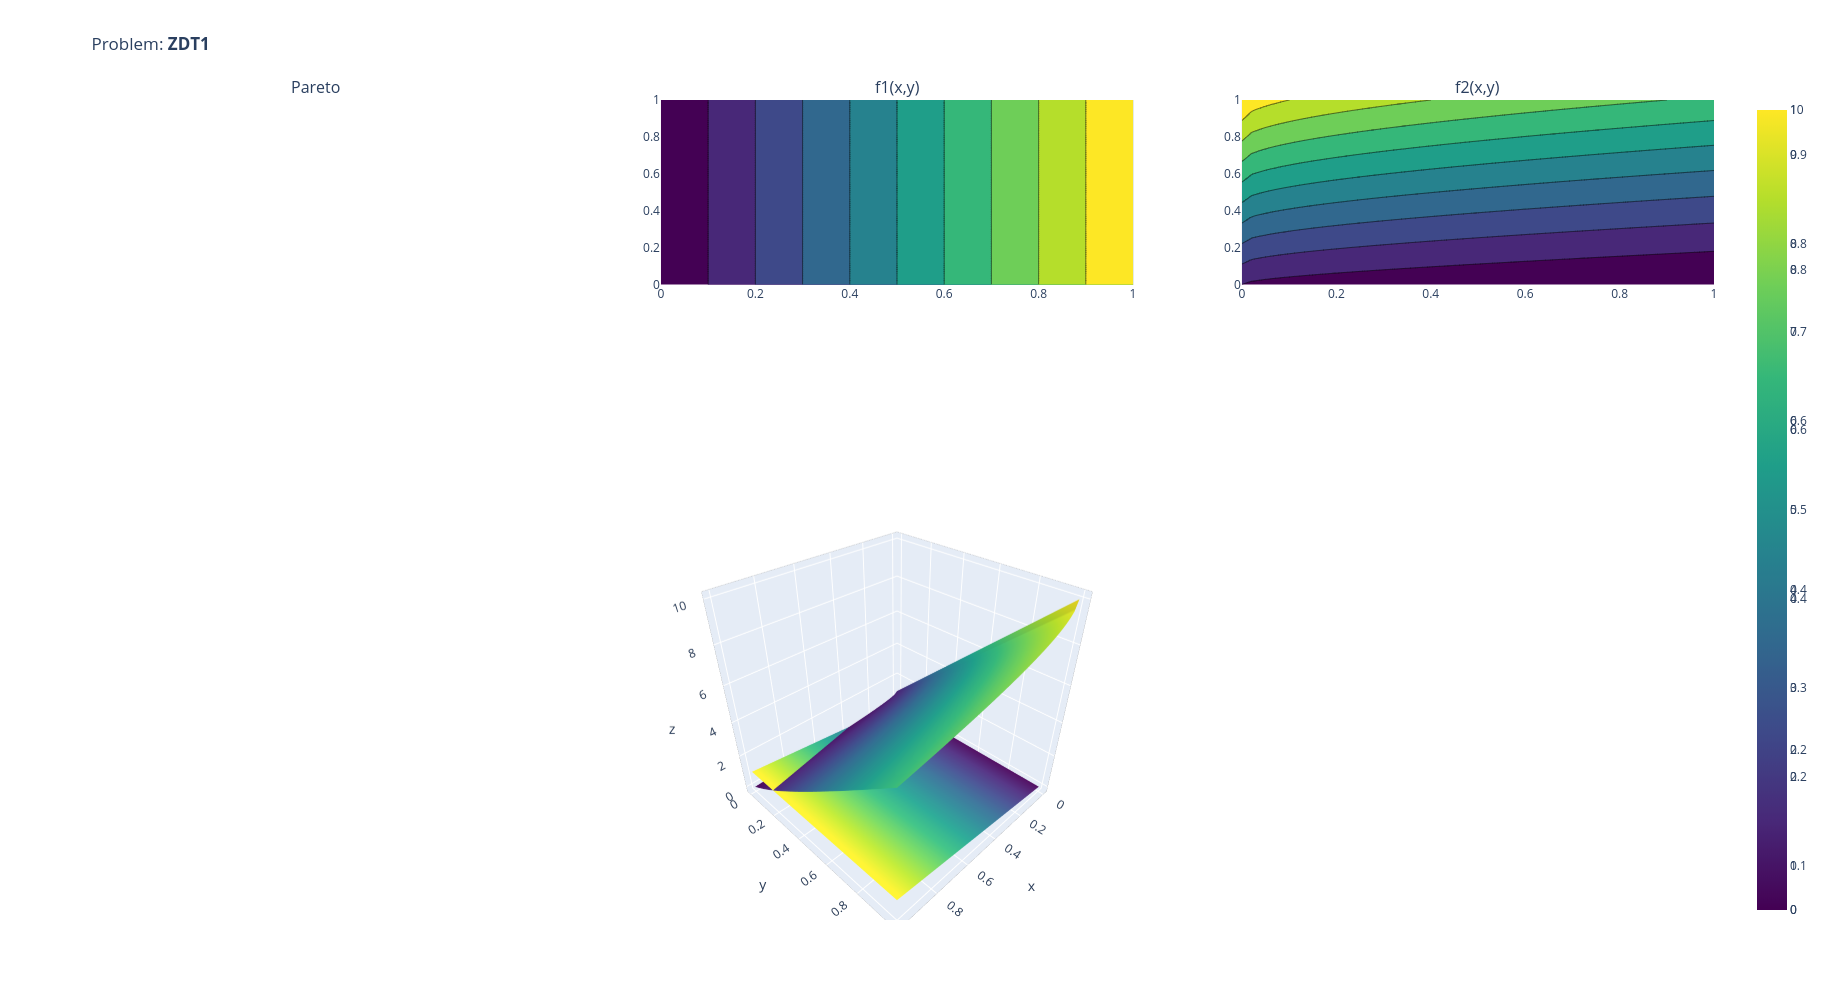

In [38]:
udp = pg.zdt(prob_id=1, param=2)
pro = pg.problem(udp)
plot_mo(pro)

In [44]:
import ipyparallel as ipp

c = ipp.Client()
c.ids

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.